<a href="https://colab.research.google.com/github/wxiongccnu1990/cngi_prototype/blob/master/images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Images
An overview of the image data structure and manipulation.

This walkthrough is designed to be run in a Jupyter notebook on Google Colaboratory. To open the notebook in colab, go [here](https://colab.research.google.com/github/casangi/cngi_prototype/blob/master/docs/images.ipynb)

In [ ]:
# TEMPORARY WORKAROUND for Python 3.7 - you must run this notebook twice!!
import os
import numpy as np

if np.__version__ != '1.20.1':
    print('updating numpy and killing runtime....\nPlease re-run this notebook (Runtime -> Run all)')
    os.system('pip install --upgrade numpy==1.20.1')
    os._exit(00)

In [ ]:
# Installation  
# for this demonstration we will use the data from the ALMA First Look at Imaging CASAguide
import os, warnings
warnings.simplefilter("ignore", category=RuntimeWarning)  # suppress warnings about nan-slices
print("installing casa6 and cngi (takes a few minutes)...")
os.system("apt-get install libgfortran3")
os.system("pip install --index-url https://casa-pip.nrao.edu:443/repository/pypi-group/simple casatasks==6.2.0.96")
os.system("pip install --index-url https://casa-pip.nrao.edu:443/repository/pypi-group/simple casadata")
os.system("pip install --extra-index-url https://test.pypi.org/simple/ cngi-prototype==0.0.73rc7")

print("downloading MeasurementSet from CASAguide First Look at Imaging...")
!gdown -q --id 1N9QSs2Hbhi-BrEHx5PA54WigXt8GGgx1
!tar -xzf sis14_twhya_calibrated_flagged.ms.tar.gz

print('complete')

installing casa6 and cngi (takes a few minutes)...
downloading MeasurementSet from CASAguide First Look at Imaging...
complete


## Initialize the Environment
`InitializeFramework` instantiates a client object (does not need to be returned and saved by caller). Once this object exists, all Dask objects automatically know to use it for parallel execution.  

```python
>>> from cngi.direct import InitializeFramework
>>> client = InitializeFramework(workers=4, memory='2GB')
>>> print(client)
<Client: 'tcp://127.0.0.1:33227' processes=4 threads=4, memory=8.00 GB>
```

Omitting this step will cause the subsequent Dask dataframe operations to use the default built-in scheduler for parallel execution (which can actually be faster on local machines anyway)

Google Colab doesn't really support the dask.distributed environment particularly well, so we will let Dask use its default scheduler.


## Create Image Data
First we need to create a CASA image by calling CASA6 tclean on the CASAguide MS

Pro tip: you can see the files being created by expanding the left navigation bar in colab (little arrow on top left) and going to "Files"

In [ ]:
from casatasks import tclean

tclean(vis='sis14_twhya_calibrated_flagged.ms', imagename='sis14_twhya_calibrated_flagged', field='5', spw='',
       specmode='cube', deconvolver='hogbom', nterms=1, imsize=[250,250], gridder='standard', cell=['0.1arcsec'],
       nchan=10, weighting='natural', threshold='0mJy', niter=5000, interactive=False, pbcor=True,
       savemodel='modelcolumn', usemask='auto-multithresh')
print('complete')

complete


tclean produces an image along with a number of supporting products (residual, pb, psf, etc) in their own separate directories.  

CNGI uses an [xarray](http://xarray.pydata.org/en/stable/data-structures.html#dataset) data model and the zarr storage format which is capable of storing all image products (of the same shape) together.

Note that the .mask image product will be renamed to 'automask' in the xarray data model and 'mask' will hold the mask pixel values extracted from the .image.

In [ ]:
from cngi.conversion import convert_image
from cngi.image import implot

image_xds = convert_image('sis14_twhya_calibrated_flagged.image')

converting Image...
processed image in 1.635047 seconds


Within the xarray dataset image, we can see a very clear definition of the image properties.  The **Dimensions** section holds the size of the image, while the **Coordinates** section defines the values of each dimension.  The actual image (and supporting products) are stored in the **Data variables** section.  Lastly, the **Attributes** section holds the remaining metadata.

Note that the variables *image*, *automask*, *mask*, *model*, *pb*, *psf*, and *residual* all share the same dimensions of 250x250x1x10 while the variable *sumwt* is a subset of dimensions 1x10

In [ ]:
print(image_xds)

<xarray.Dataset>
Dimensions:            (chan: 10, l: 250, m: 250, pol: 1, time: 1)
Coordinates:
  * chan               (chan) float64 3.725e+11 3.725e+11 ... 3.725e+11
    declination        (l, m) float64 dask.array<chunksize=(250, 250), meta=np.ndarray>
  * l                  (l) float64 6.06e-05 6.012e-05 ... -5.963e-05 -6.012e-05
  * m                  (m) float64 -6.06e-05 -6.012e-05 ... 5.963e-05 6.012e-05
  * pol                (pol) float64 1.0
    right_ascension    (l, m) float64 dask.array<chunksize=(250, 250), meta=np.ndarray>
  * time               (time) datetime64[ns] 2012-11-19T07:56:26.544000626
Data variables:
    AUTOMASK           (l, m, time, chan, pol) float64 dask.array<chunksize=(250, 250, 1, 1, 1), meta=np.ndarray>
    IMAGE              (l, m, time, chan, pol) float64 dask.array<chunksize=(250, 250, 1, 1, 1), meta=np.ndarray>
    IMAGE_MASK0        (l, m, time, chan, pol) bool dask.array<chunksize=(250, 250, 1, 1, 1), meta=np.ndarray>
    IMAGE_PBCOR        (

The image has both cartesian pixel coordinates (l, m) and spherical world coordinates (right_ascension, declination).

The spherical nature of the multi-dimensional right_ascension and declination coordinate structures becomes clearer when we plot a very wide image:

converting Image...
processed image in 0.9296875 seconds


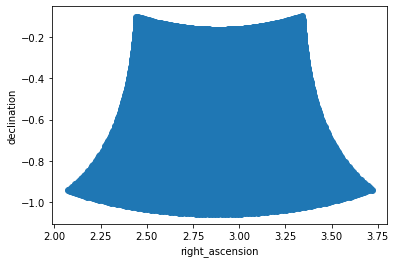

In [ ]:
tclean(vis='sis14_twhya_calibrated_flagged.ms', imagename='wide_cube', field='5', spw='', specmode='cube', cell='30arcmin',
       imsize=100, nchan=10, deconvolver='hogbom', niter=10, savemodel='modelcolumn', usemask='auto-multithresh')

widexds = convert_image('wide_cube.image')
widexds.plot.scatter(x='right_ascension', y='declination')

## Preview Image
We can quickly spot check image contents.  This is also handy later on during image manipulation and analysis.  Most image data is four-dimensional, so the plotting routine will collapse extra dimensions by taking the max (this is more robust than mean).

The image can be plotted using its spherical world coordinates or cartesian pixel indices

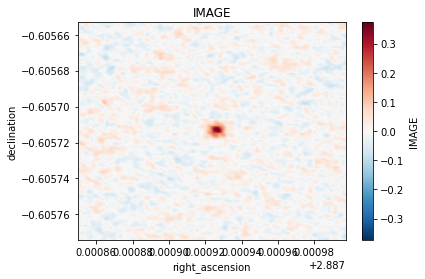

In [ ]:
from cngi.image import implot

# just channel 5
implot(image_xds.IMAGE, axis=['right_ascension', 'declination'], chans=5)

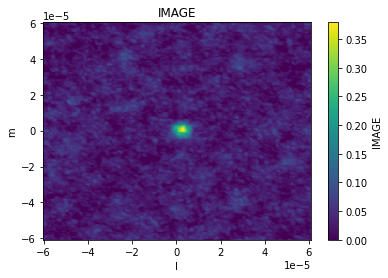

In [ ]:
# max of all channels, with cartesian pixel indices
implot(image_xds.IMAGE, axis=['l', 'm'], chans=None)

Other image data products are plotted the same way

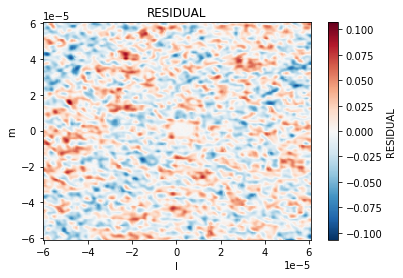

In [ ]:
implot(image_xds.RESIDUAL, chans=5)

The plotting function has the same capabilities as the visibility routine, so we can also make scatter plots across coordinates and dimensions using the axis parameter. Other dimensions are collapsed by taking the max.

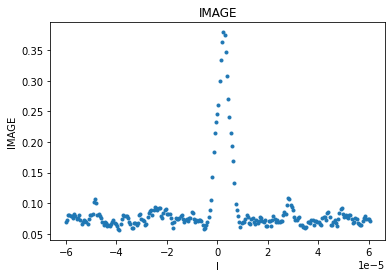

In [ ]:
implot(image_xds.IMAGE, axis='l')

Looking across channels, it is clear that channel 0 is empty.  This is why the above plot across all channels is rescaled to a min value of 0.

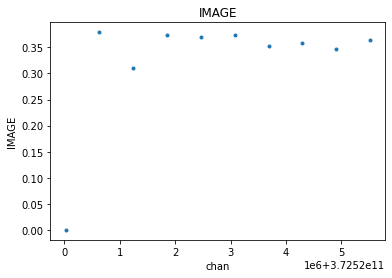

In [ ]:
implot(image_xds.IMAGE, axis='chan')

## Basic Manipulation
Many image operations can be easily done directly on the image xarray dataset

**Example 1: imsubimage** - copy all or part of an image to a new image

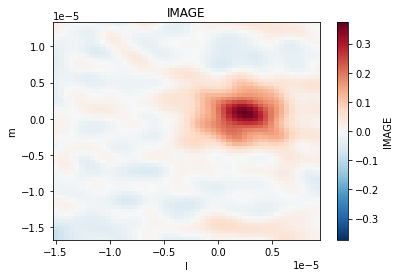

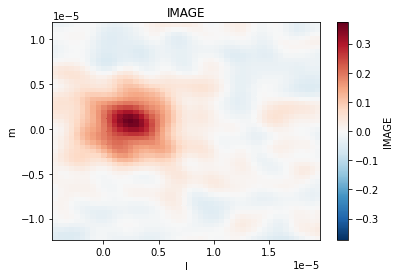

In [ ]:
# selection by coordinate values
image_xds2 = image_xds.where( (image_xds.right_ascension > 2.887905) & (image_xds.right_ascension < 2.887935) &
                              (image_xds.declination > -0.60573) & (image_xds.declination < -0.60570), drop=True ) 
implot(image_xds2.IMAGE, chans=5)

# selection by pixel indices (50x50 pixel square)
# note that this same method works for any other dimension (stokes, channels, etc)
image_xds2 = image_xds.isel(l=range(85,135), m=range(100,150))
implot(image_xds2.IMAGE, chans=5)

**Example 2: imtrans** - reorders (transposes) the axes in the input image to the specified order

This can be done on the entire dataset, or just one variable in the dataset. Here we will do it on the whole thing which is probably best if you want to preserve your regions and masks (explained later).  This will generally not affect the preview plot since it selects axes by name rather than index. That is one advantage of xarray over numpy.

In [ ]:
image_xds2 = image_xds.transpose('chan','m','time','l','pol')
print('Before\n', image_xds.data_vars)
print('\nAfter\n', image_xds2.data_vars)

Before
 Data variables:
    AUTOMASK           (l, m, time, chan, pol) float64 dask.array<chunksize=(250, 250, 1, 1, 1), meta=np.ndarray>
    IMAGE              (l, m, time, chan, pol) float64 dask.array<chunksize=(250, 250, 1, 1, 1), meta=np.ndarray>
    IMAGE_MASK0        (l, m, time, chan, pol) bool dask.array<chunksize=(250, 250, 1, 1, 1), meta=np.ndarray>
    IMAGE_PBCOR        (l, m, time, chan, pol) float64 dask.array<chunksize=(250, 250, 1, 1, 1), meta=np.ndarray>
    IMAGE_PBCOR_MASK0  (l, m, time, chan, pol) bool dask.array<chunksize=(250, 250, 1, 1, 1), meta=np.ndarray>
    MODEL              (l, m, time, chan, pol) float64 dask.array<chunksize=(250, 250, 1, 1, 1), meta=np.ndarray>
    PB                 (l, m, time, chan, pol) float64 dask.array<chunksize=(250, 250, 1, 1, 1), meta=np.ndarray>
    PB_MASK0           (l, m, time, chan, pol) bool dask.array<chunksize=(250, 250, 1, 1, 1), meta=np.ndarray>
    PSF                (l, m, time, chan, pol) float64 dask.array<chunksi

**Example 3: imcollapse** - collapse an image along a specified axis or set of axes of N pixels into a single pixel on each specified axis.

Again, this can be done on the entire dataset, or just one variable in the dataset. Refer to the [xarray documentation](http://xarray.pydata.org/en/stable/api.html#dataset) for supported aggregation functions, or write your own and call *reduce*.  This will generally break the preview plot since it is expecting a 4-D cube with ra, dec, stokes, and frequency axes

In [ ]:
# one dimension collapse
image_xds2 = image_xds.sum(dim='chan')
print('One dimension collapse\n', image_xds2.data_vars)

# multi-dimension collapse
image_xds2 = image_xds.mean(dim=['l','m'])
print('\nMulti-dimension collapse\n', image_xds2.data_vars)


One dimension collapse
 Data variables:
    AUTOMASK           (l, m, time, pol) float64 dask.array<chunksize=(250, 250, 1, 1), meta=np.ndarray>
    IMAGE              (l, m, time, pol) float64 dask.array<chunksize=(250, 250, 1, 1), meta=np.ndarray>
    IMAGE_MASK0        (l, m, time, pol) int64 dask.array<chunksize=(250, 250, 1, 1), meta=np.ndarray>
    IMAGE_PBCOR        (l, m, time, pol) float64 dask.array<chunksize=(250, 250, 1, 1), meta=np.ndarray>
    IMAGE_PBCOR_MASK0  (l, m, time, pol) int64 dask.array<chunksize=(250, 250, 1, 1), meta=np.ndarray>
    MODEL              (l, m, time, pol) float64 dask.array<chunksize=(250, 250, 1, 1), meta=np.ndarray>
    PB                 (l, m, time, pol) float64 dask.array<chunksize=(250, 250, 1, 1), meta=np.ndarray>
    PB_MASK0           (l, m, time, pol) int64 dask.array<chunksize=(250, 250, 1, 1), meta=np.ndarray>
    PSF                (l, m, time, pol) float64 dask.array<chunksize=(250, 250, 1, 1), meta=np.ndarray>
    RESIDUAL         

## Regions and Masks
Both regions and masks are stored as boolean arrays in the same xarray dataset alongside the rest of the image components.  They always share the same dimensions as the image.

They are both now treated as the same thing, so a value of 0 means "discard this pixel" and a value of 1 means "keep this pixel" regardless of whether it is a mask or a region.  In fact, any xarray data variable of boolean type can be used as a region/mask, there is nothing special about the names.

Regions/masks can be set across any dimension, so they can be per-channel and per-stokes as well as the spatial dimensions.


### Regions

First lets create a couple examples:

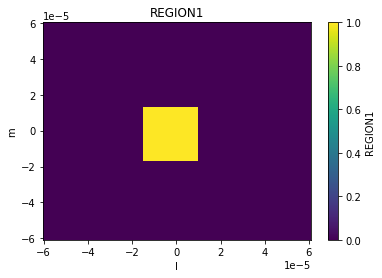

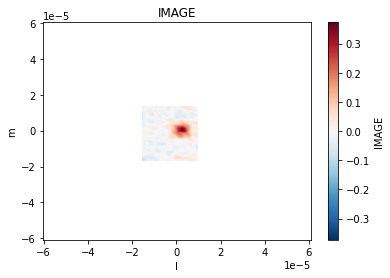

In [ ]:
from cngi.image import region

# region 1 is an ra/dec box across all channels
image_xds2 = region(image_xds, 'REGION1', ra=[2.887905, 2.887935], dec=[-0.60573, -0.60570])

# lets examine what it looks like
implot(image_xds2.REGION1, chans=5)

# and combined with our image
implot(image_xds2.IMAGE.where(image_xds2.REGION1), chans=5)

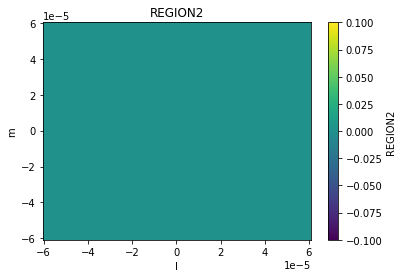

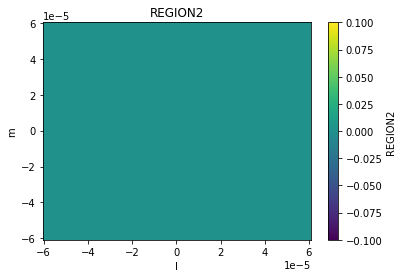

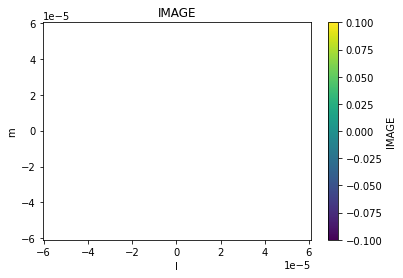

In [ ]:
# region 2 is a pixel box across channels 3, 4 and 5
image_xds3 = region(image_xds2, 'REGION2', pixels=[[85,100],[135,150]], channels=[3,4,5])

# observe the change in behavior across channels
implot(image_xds3.REGION2, chans=5)
implot(image_xds3.REGION2, chans=6)
implot(image_xds3.IMAGE.where(image_xds3.REGION2), chans=[5,6])

Regions are just data variables in the xarray dataset. So we can manipulate them the same way we can any other variable.

In [ ]:
image_xds3.data_vars

Data variables:
    AUTOMASK           (l, m, time, chan, pol) float64 dask.array<chunksize=(250, 250, 1, 1, 1), meta=np.ndarray>
    IMAGE              (l, m, time, chan, pol) float64 dask.array<chunksize=(250, 250, 1, 1, 1), meta=np.ndarray>
    IMAGE_MASK0        (l, m, time, chan, pol) bool dask.array<chunksize=(250, 250, 1, 1, 1), meta=np.ndarray>
    IMAGE_PBCOR        (l, m, time, chan, pol) float64 dask.array<chunksize=(250, 250, 1, 1, 1), meta=np.ndarray>
    IMAGE_PBCOR_MASK0  (l, m, time, chan, pol) bool dask.array<chunksize=(250, 250, 1, 1, 1), meta=np.ndarray>
    MODEL              (l, m, time, chan, pol) float64 dask.array<chunksize=(250, 250, 1, 1, 1), meta=np.ndarray>
    PB                 (l, m, time, chan, pol) float64 dask.array<chunksize=(250, 250, 1, 1, 1), meta=np.ndarray>
    PB_MASK0           (l, m, time, chan, pol) bool dask.array<chunksize=(250, 250, 1, 1, 1), meta=np.ndarray>
    PSF                (l, m, time, chan, pol) float64 dask.array<chunksize=(250,

Let's combine the first two regions in to a new one (doesn't need to be contiguous, although it is here). It is just a logical OR of two boolean arrays (obviously you could do an AND, XOR, or whatever else).

Just keep in mind that these are 4-D arrays, not 2-D.

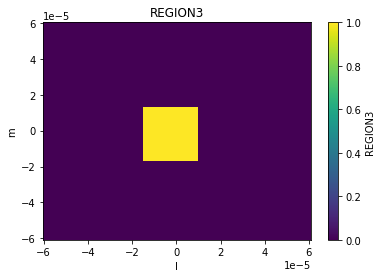

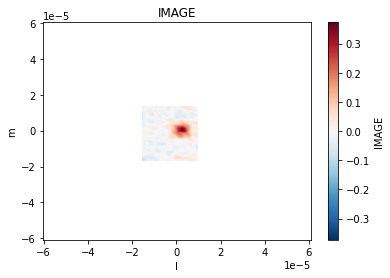

In [ ]:
region3 = image_xds3.REGION1 | image_xds3.REGION2
image_xds4 = image_xds3.assign(dict([('REGION3', region3)]))
 
implot(image_xds4.REGION3, chans=5)
implot(image_xds4.IMAGE.where(image_xds4.REGION3), chans=5)

### Masks

Masks are just like regions but with inverse logic used to set them.  Here is the same code again using calls to mask instead of region.

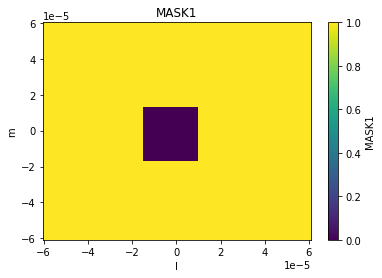

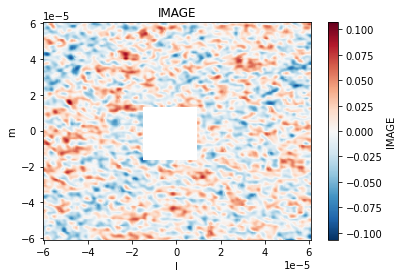

In [ ]:
from cngi.image import mask

image_xds2 = mask(image_xds, 'MASK1', ra=[2.887905, 2.887935], dec=[-0.60573, -0.60570])

implot(image_xds2.MASK1, chans=5)
implot(image_xds2.IMAGE.where(image_xds2.MASK1), chans=5)

Our converted image actually had two masks in it already, the variables *mask* and *deconvolve*.  Deconvolve is named differently because it is the mask set by auto-masking for the deconvolution rather than an image mask.  

These actually look a lot more like regions than masks, but that's the terminology that was used.  Again, they are the same thing anyway

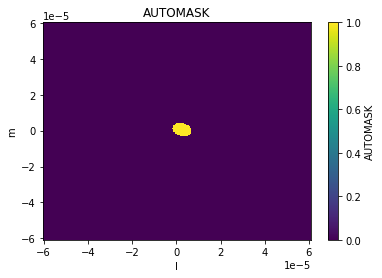

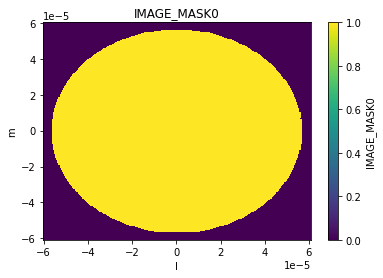

In [ ]:
implot(image_xds2.AUTOMASK, chans=5)
implot(image_xds2.IMAGE_MASK0, chans=5)

### Manipulation with Regions and Masks

All of the previously discussed image manipulation techniques can be done with regions and masks applied.  Just subselect the pixels within the region (outside the mask) first.  This is done with *dataset.where(..., drop=True)* 

Here is example 3 again with a region applied.

**Example 3: imcollapse** - collapse an image along a specified axis or set of axes of N pixels into a single pixel on each specified axis.

Mean pixel values by channel :  [[0.         0.0009337  0.00062645 0.00089679 0.00076623 0.00075292
  0.00072544 0.00098671 0.00082494 0.00076202]] 



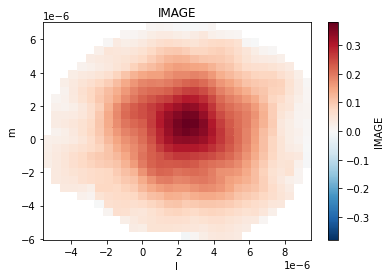


With deconvolve mask applied :  [[0.10398342 0.09321038 0.11130808 0.18811813 0.18880715 0.11977939
  0.12009658 0.09283661 0.10214104]]


In [ ]:
# full image collapse
image_xds2 = image_xds.mean(dim=['l','m'])
print('Mean pixel values by channel : ', image_xds2.isel(pol=0).IMAGE.values, '\n')

# apply deconvolve region from auto-masking
image_xds2 = image_xds.where(image_xds.AUTOMASK, drop=True)
implot(image_xds2.IMAGE)

# collapse just the region
image_xds2 = image_xds2.mean(dim=['l','m'])
print('\nWith deconvolve mask applied : ', image_xds2.isel(pol=0).IMAGE.values)

## Beams and Smoothing
Smoothing an image involves creating and convolving beams of appropriate parameters to achieve the desired target properties in the image.

### Creating Beams
Beams may be created as additional products in the image xarray Dataset. They may also be present already in parameterized form inside the attributes section.

First lets expand the parameterized per-plane beams defined in the xds attributes section.  This beam is defined across the channels and polarization axes.

restoring beam parameters (chan 5) :  [[0.6530477404594421, 0.5046632885932922, -66.00917053222656]]


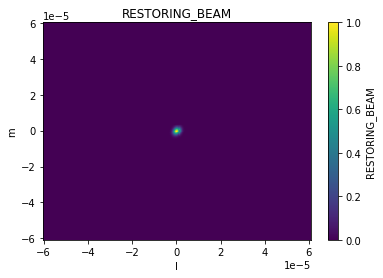

restoring beam dimensions:  (250, 250, 10, 1)


In [ ]:
from cngi.image import gaussian_beam

print('restoring beam parameters (chan 5) : ', image_xds.perplanebeams[5])

image_xds2 = gaussian_beam(image_xds, source='perplanebeams', name='RESTORING_BEAM')

implot(image_xds2.RESTORING_BEAM)
print('restoring beam dimensions: ', image_xds2.RESTORING_BEAM.shape)

Now lets create a larger beam from our own parameters.  This one has only spatial dimensions.

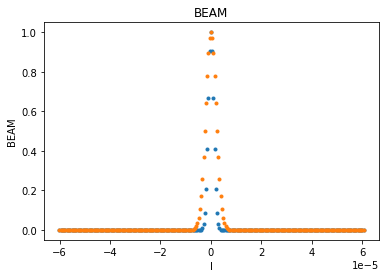

custom beam dimensions:  (250, 250)


In [ ]:
image_xds2 = gaussian_beam(image_xds2, source=[1., 1., 30], name='BEAM')

implot(image_xds2.RESTORING_BEAM, 'l', drawplot=False)
implot(image_xds2.BEAM, 'l', overplot=True)
print('custom beam dimensions: ', image_xds2.BEAM.shape)

### Smoothing with Beams

The smooth function can take an existing beam and convolve it across the image to produce a new output image. 

original image


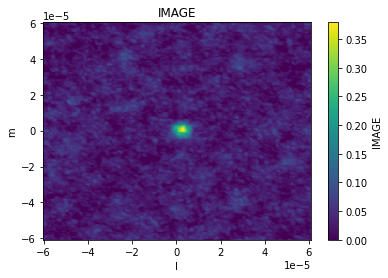

smooth image


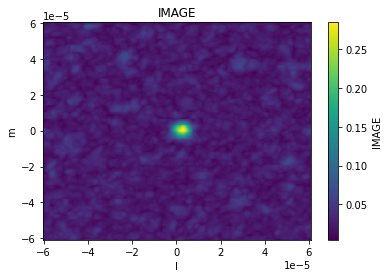

In [ ]:
from cngi.image import smooth

# smooth with the restoring beam
image_xds3 = smooth(image_xds2, kernel='RESTORING_BEAM')

print('original image')
implot(image_xds2.IMAGE)

print('smooth image')
implot(image_xds3.IMAGE)

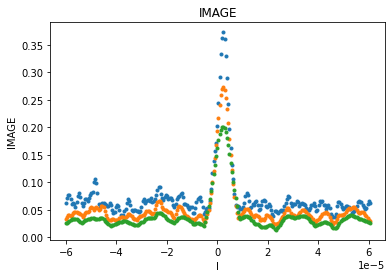

In [ ]:
# smooth with our larger custom beam
image_xds4 = smooth(image_xds2, kernel='BEAM')

implot(image_xds.IMAGE, axis='l', chans=5, drawplot=False)
implot(image_xds3.IMAGE, axis='l', chans=5, overplot=True, drawplot=False)
implot(image_xds4.IMAGE, axis='l', chans=5, overplot=True)

If the image has already been smoothed by a previous beam, the smooth function can take the parameters of a new desired beam and construct the appropriate correcting beam to produce that target. The correcting beam used for smoothing is saved in the output xarray Dataset.

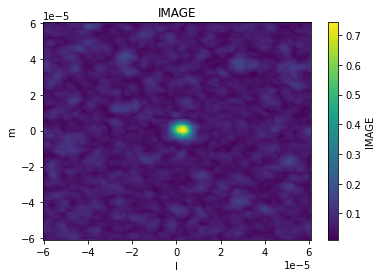

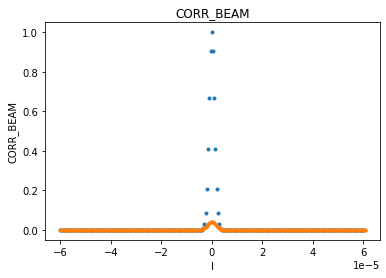

In [ ]:
image_xds3 = smooth(image_xds2, kernel='gaussian', size=(1., 1., 60.), current=(0.65305, 0.50467, -66.), name='CORR_BEAM')

implot(image_xds3.IMAGE)
implot(image_xds3.RESTORING_BEAM, axis='l', chans=5, drawplot=False)
implot(image_xds3.CORR_BEAM, axis='l', overplot=True)



## Moments


The moments function can compute moments from an image. The spectral moment distributions at each pixel are determined. The main control of the calculation is given by the parameter moment:

*   moments = -1 - mean value of the spectrum
*   moments =  0 - integrated value of the spectrum

*   moments =  1 - intensity weighted coordinate; traditionally used to get "velocity fields"

*   moments =  2 - intensity weighted dispersion of the coordinate; traditionally used to get 

*   moments =  3 - median value of the spectrum
*   moments =  4 - median coordinate


*   moments =  5 - standard deviation about the mean of the spectrum


*   moments =  6 - root mean square of the spectrum


*   moments =  7 - absolute mean deviation of the spectrum

*   moments =  8 - maximum value of the spectrum
*   moments =  9 - coordinate of the maximum value of the spectrum


*   moments = 10 - minimum value of the spectrum

*   moments = 11 - coordinate of the minimum value of the spectrum






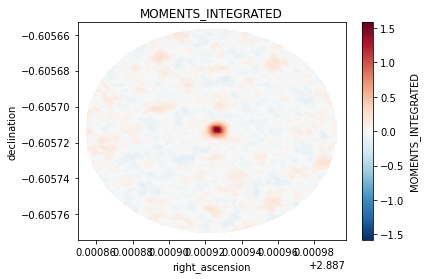

In [ ]:
# Example for creating the "moment 0" map,
from cngi.image import moments, implot

image_xds2 = moments(image_xds, moment=0, axis='chan')

implot(image_xds2.MOMENTS_INTEGRATED.where(image_xds2.IMAGE_MASK0),axis=['right_ascension', 'declination'])

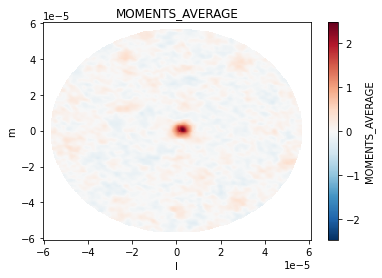

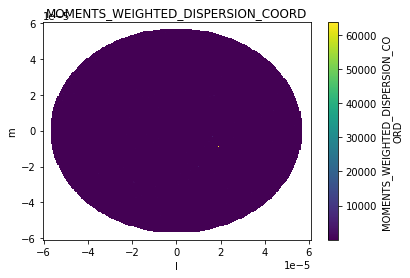

In [ ]:
# Example for creating selected moment maps for selected channels
image_xds2 = moments(image_xds.isel(chan=[2,3,4,5,6,7,8]), moment = [-1,2])

implot(image_xds2.MOMENTS_AVERAGE.where(image_xds2.IMAGE_MASK0))
implot(image_xds2.MOMENTS_WEIGHTED_DISPERSION_COORD.where(image_xds2.IMAGE_MASK0))

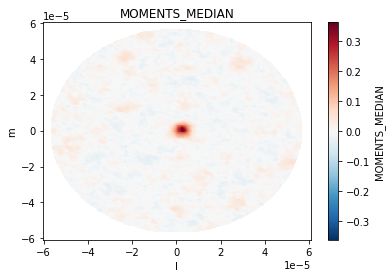

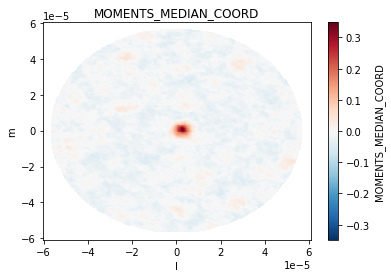

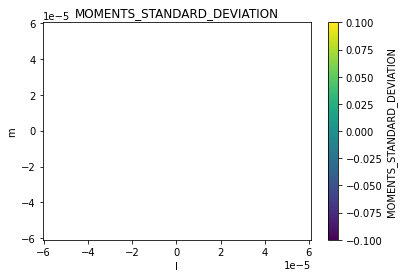

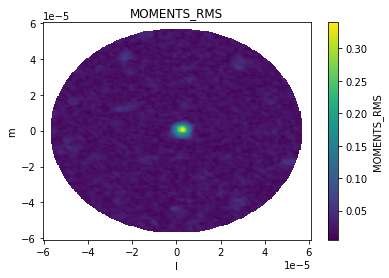

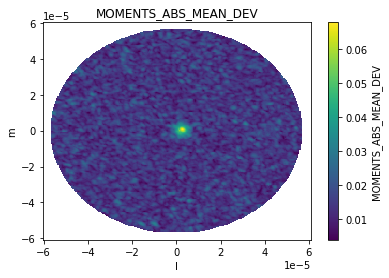

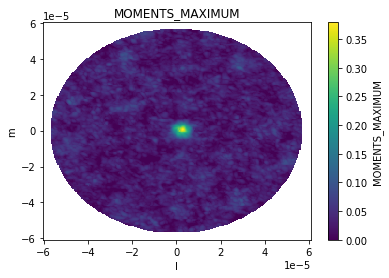

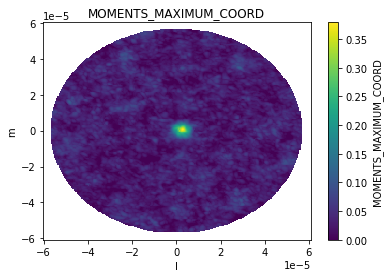

In [ ]:
# Example for calculating with default settings: all channels and all moments.
image_xds2 = moments(image_xds)

implot(image_xds2.MOMENTS_MEDIAN.where(image_xds2.IMAGE_MASK0))
implot(image_xds2.MOMENTS_MEDIAN_COORD.where(image_xds2.IMAGE_MASK0))
implot(image_xds2.MOMENTS_STANDARD_DEVIATION.where(image_xds2.IMAGE_MASK0))
implot(image_xds2.MOMENTS_RMS.where(image_xds2.IMAGE_MASK0))
implot(image_xds2.MOMENTS_ABS_MEAN_DEV.where(image_xds2.IMAGE_MASK0))
implot(image_xds2.MOMENTS_MAXIMUM.where(image_xds2.IMAGE_MASK0))
implot(image_xds2.MOMENTS_MAXIMUM_COORD.where(image_xds2.IMAGE_MASK0))
#implot(image_xds2.MOMENTS_MINIMUM.where(image_xds2.IMAGE_MASK0))
#implot(image_xds2.MOMENTS_MINIMUM_COORD.where(image_xds2.IMAGE_MASK0))

## Statistics

Displays statistical information from an image.

*   npts:  the number of unmasked points used
*   sum:   the sum of the pixel values

*   sumsq: the sum of the squares of the pixel value

*   mean:  the mean of pixel values

*   sigma: the standard deviation about the mean

*   rms:   the root mean sqaure

*   min:   the minimum pixel value
*   max:   the maximum pixel value


*   median:the median pixel value


*   medabsdevmed: the median of the absolute deviations from the median


*   q1:    the first quartile


*   q3:    the third quartile

*   quartile: the inter-quartile range (if robust=T). Find the points which are 25% largest and 75% largest (the median is 50% largest).
*   blc:   the absolute pixel coordinate of the bottom left corner of the bounding box of the region of interest.


*   blcf:  the formatted absolute world coordinate of the bottom left corner of the bounding box of the region of interest.

*   trc:   the absolute pixel coordinate of the top right corner of the bounding box of the region of interest.

*   trcf:  the formatted absolute world coordinate of the top right corner of the bounding box of the region of interest.
*   minpos:absolute pixel coordinate of minimum pixel value


*   maxpos:absolute pixel coordinate of maximum pixel value


*   minpos:the formatted absolute pixel coordinate of minimum pixel value

*   maxpos:the formatted absolute pixel coordinate of maximum pixel value

In [ ]:
# Example of Directly call using default setting, and print the statistical results
from cngi.image import statistics

image_xds2 = statistics(image_xds)

for kk in image_xds2.statistics:
  print(kk, ' : ', image_xds2.statistics[kk])

blc  :  [0, 0, 0, 0, 0]
blcf  :  ['11:01:52.8097', '-34.42.29.8657', array(3.72520023e+11), array(1.), 0]
max  :  0.3790925145149231
maxpos  :  [120, 127, 0, 1, 0]
maxposf  :  ['11:01:51.8365', '-34.42.17.166', array(3.72520633e+11), array(1.), 0]
mean  :  0.0007275201077141245
medabsdevmed  :  [0.         0.01492186 0.01504212 0.01531607 0.01586758 0.01658201
 0.01494189 0.0155636  0.0159588  0.01572468]
median  :  [ 0.00000000e+00  2.14301384e-04 -7.04558042e-05 -2.27670484e-04
 -5.83573623e-04 -4.02509191e-04 -5.61238430e-05  2.34902318e-05
 -1.14151611e-04 -3.09934127e-04]
min  :  -0.11142729222774506
minpos  :  [208, 245, 0, 2, 0]
minposf  :  ['11:01:51.123', '-34.42.05.3659', array(3.72521243e+11), array(1.), 0]
npts  :  625000
q1  :  -0.013601564336568117
q3  :  0.0135584797244519
quartile  :  0.027160044061020017
rms  :  0.0247616230541653
sigma  :  0.024750933129266912
sum  :  454.70006732132777
sumsq  :  383.2112351728566
trc  :  [249, 249, 0, 9, 0]
trcf  :  ['11:01:50.7905',

In [ ]:
# Example of select channels, then the mean and standard deviation are printed
image_xds2 = statistics(image_xds.isel(chan=list(range(2,10))))

print("Mean :", image_xds2.statistics['mean'])
print("Standard deviation :", image_xds2.statistics['sigma'])

Mean : 0.0007926878016913481
Standard deviation : 0.0261329584125846


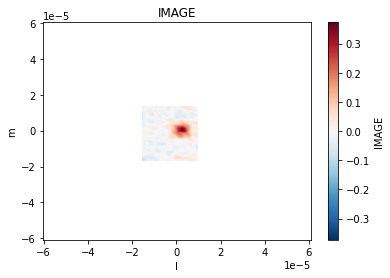

blc  :  [0, 0, 0, 0, 0]
blcf  :  ['11:01:52.8097', '-34.42.29.8657', array(3.72520023e+11), array(1.), 0]
max  :  0.3790925145149231
maxpos  :  [120, 127, 0, 1, 0]
maxposf  :  ['11:01:51.8365', '-34.42.17.166', array(3.72520633e+11), array(1.), 0]
mean  :  0.015030238827784124
medabsdevmed  :  [nan nan nan nan nan nan nan nan nan nan]
median  :  [0.         0.00237319 0.00292684 0.00310421 0.00319308 0.00013027
 0.0017834  0.00420967 0.00430223 0.00501225]
min  :  -0.0871538370847702
minpos  :  [156, 92, 0, 5, 0]
minposf  :  ['11:01:51.5446', '-34.42.20.666', array(3.72523074e+11), array(1.), 0]
npts  :  625000
q1  :  -0.011477575171738863
q3  :  0.020991315133869648
quartile  :  0.03246889030560851
rms  :  0.012744431501437035
sigma  :  0.05463049950296125
sum  :  475.256151734534
sumsq  :  101.5128339342629
trc  :  [249, 249, 0, 9, 0]
trcf  :  ['11:01:50.7905', '-34.42.04.9657', array(3.72525516e+11), array(1.), 0]


In [ ]:
# Example of select region and print the statistics.
from cngi.image import region

# region 1 is an ra/dec box across all channels
image_xds2 = region(image_xds, 'REGION1', ra=[2.887905, 2.887935], dec=[-0.60573, -0.60570])
image_xds2 = statistics(image_xds2.where(image_xds2.REGION1))

implot(image_xds2.IMAGE.where(image_xds2.REGION1), chans=5)

for kk in image_xds2.statistics:
  print(kk,' : ', image_xds2.statistics[kk])

## Continuum Subtraction
The image cont_sub function estimates and subtracts continuum emission from an image cube.




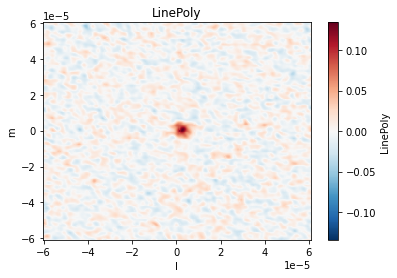

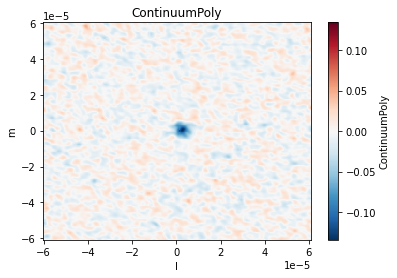

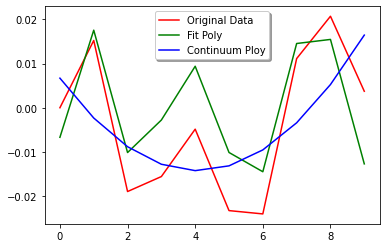

In [ ]:
# Example of Directly call using default setting. 
from cngi.image import cont_sub
from cngi.image import implot
import matplotlib.pyplot as plt

image_xds2=cont_sub(image_xds)

implot(image_xds2.LinePoly, chans = 0)
implot(image_xds2.ContinuumPoly, chans = 0)

# Create plots with pre-defined labels.
fig, ax = plt.subplots()
x = [i for i in range(image_xds2.IMAGE.shape[3])]

ax.plot(x, image_xds2.IMAGE[0,0,0,:,0], label='Original Data',color='r')
ax.plot(x, image_xds2.ContinuumPoly[0,0,0,:,0], label='Fit Poly',color='g')
ax.plot(x, image_xds2.LinePoly[0,0,0,:,0], label='Continuum Ploy',color='b')
legend = ax.legend(loc='upper center', shadow=True)

plt.show()

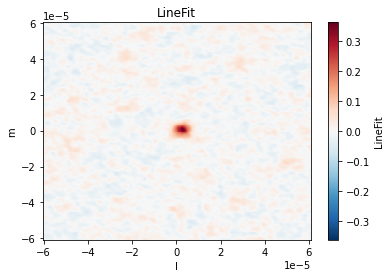

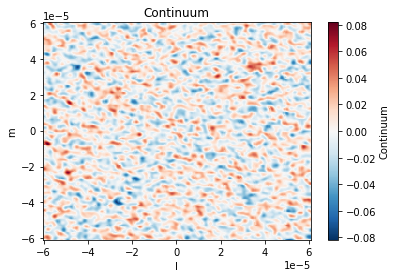

In [ ]:
# Fit a second order polynomial (fitorder=2) to channels 3-5 and 7-9 to an RA x Dec x Frequency x Stokes cube. 
# Save fitting model and continuum emission data using user defined names.

image_xds2 = cont_sub(image_xds, linename='LineFit', continuumname = 'Continuum', fitOrder=2, chans = '3~8, 7~9')

implot(image_xds2.LineFit,chans = 5)
implot(image_xds2.Continuum,chans = 5)


## Spectral Line Fitting Proof of Concept
Adapted from https://github.com/emilyripka/BlogRepo/blob/master/181119_PeakFitting.ipynb
Dave Mehringer 2021mar01

In [ ]:
# Create a blank image in CASA 6
import casatools
import numpy as np
myia = casatools.image()
nchan = 100
myia.fromshape("gaussfit.im",[20,20,nchan,1], overwrite=True)
# insert the model spectrum
x_vals = np.linspace(0,nchan-1,nchan)
amp1 = 20
sigma1 = 10
cen1 = nchan/2
y_vals = amp1*(np.exp((-1.0/2.0)*(((x_vals-cen1)/sigma1)**2)))
pix = myia.getchunk()
pix[10, 10, :, 0] = y_vals
myia.putchunk(pix)
# add some noise
myia.addnoise()
myia.done()
# convert to CNGI image
image_xds10 = convert_image('gaussfit.im')
print(image_xds10)

converting Image...
processed image in 0.44272256 seconds
<xarray.Dataset>
Dimensions:          (chan: 100, l: 20, m: 20, pol: 1, time: 1)
Coordinates:
  * chan             (chan) float64 1.415e+09 1.415e+09 ... 1.415e+09 1.415e+09
    declination      (l, m) float64 dask.array<chunksize=(20, 20), meta=np.ndarray>
  * l                (l) float64 10.0 9.0 8.0 7.0 6.0 ... -6.0 -7.0 -8.0 -9.0
  * m                (m) float64 -10.0 -9.0 -8.0 -7.0 -6.0 ... 6.0 7.0 8.0 9.0
  * pol              (pol) float64 1.0
    right_ascension  (l, m) float64 dask.array<chunksize=(20, 20), meta=np.ndarray>
  * time             (time) datetime64[ns] 2000-01-01T00:00:00.000100136
Data variables:
    IM               (l, m, time, chan, pol) float64 dask.array<chunksize=(20, 20, 1, 1, 1), meta=np.ndarray>
Attributes:
    axisnames:            ['Right Ascension', 'Declination', 'Time', 'Stokes'...
    axisunits:            ["'", "'", 'datetime64[ns]', '', 'Hz']
    date_observation:     2000/01/01/00
    dir

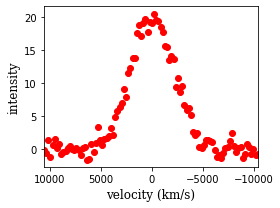

In [ ]:
# convert freqs to velocities
import scipy
restf = image_xds10.chan[50]
vel = -(image_xds10.chan-restf)/restf*scipy.constants.c

# plot the spectrum
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec

fig = plt.figure(figsize=(4,3))
gs = gridspec.GridSpec(1,1)
ax1 = fig.add_subplot(gs[0])
ax1.plot(vel, image_xds10.IM[10,10,0,:,0], "ro")
ax1.set_xlim(vel.max(), vel.min())
ax1.set_xlabel("velocity (km/s)",family="serif",  fontsize=12)
ax1.set_ylabel("intensity",family="serif",  fontsize=12)
fig.tight_layout()
fig.savefig("rawGaussian.png", format="png",dpi=1000)

In [ ]:
# do the fit and print the results

def _1gaussian(x, amp1,cen1,sigma1):
    return amp1*(np.exp((-1.0/2.0)*(((vel-cen1)/sigma1)**2)))
popt_gauss, pcov_gauss = scipy.optimize.curve_fit(_1gaussian, vel, image_xds10.IM[10,10,0,:,0], p0=[amp1, vel[50], 2000])

perr_gauss = np.sqrt(np.diag(pcov_gauss))

print(f"amplitude = {popt_gauss[0]:0.2f} (+/-) {perr_gauss[0]:0.2f} Jy/beam")
print(f"center = {popt_gauss[1]: 0.2f} (+/-) {perr_gauss[1]:0.2f} km/s")
print(f"sigma = {popt_gauss[2]: 0.2f} (+/-) {perr_gauss[2]:0.2f} km/s")

amplitude = 19.96 (+/-) 0.28 Jy/beam
center = -20.58 (+/-) 34.23 km/s
sigma =  2131.81 (+/-) 34.23 km/s


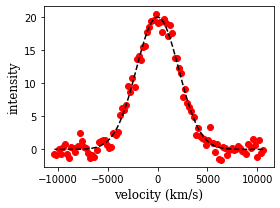

In [ ]:
# Plot the data and the fit
fig = plt.figure(figsize=(4,3))
gs = gridspec.GridSpec(1,1)
ax1 = fig.add_subplot(gs[0])

ax1.plot(vel, image_xds10.IM[10,10,0,:,0], "ro")
ax1.plot(vel, _1gaussian(vel, *popt_gauss), 'k--')

ax1.set_xlabel("velocity (km/s)",family="serif",  fontsize=12)
ax1.set_ylabel("intensity",family="serif",  fontsize=12)

fig.tight_layout()
fig.savefig("fitGaussian.png", format="png",dpi=1000)